In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from collections import defaultdict
from PIL import Image
import numpy as np
import cv2

### 경로 설정

In [3]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정
traindata_dir = "./data/train"
traindata_info_file = "./data/train.csv"

# 테스트 데이터의 경로와 정보를 가진 파일의 경로를 설정
testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"

### 파일 정보 확인

In [4]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기
train_data = pd.read_csv(traindata_info_file)

# 테스트 데이터
test_data = pd.read_csv(testdata_info_file)

In [5]:
# 학습 데이터의 정보를 출력
train_info = train_data.info()
train_head = train_data.head()

train_info, train_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15021 entries, 0 to 15020
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  15021 non-null  object
 1   image_path  15021 non-null  object
 2   target      15021 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 352.2+ KB


(None,
   class_name                image_path  target
 0  n01872401  n01872401/sketch_50.JPEG      59
 1  n02417914  n02417914/sketch_11.JPEG     202
 2  n02106166   n02106166/sketch_3.JPEG     138
 3  n04235860   n04235860/sketch_2.JPEG     382
 4  n02056570  n02056570/sketch_40.JPEG      80)

In [6]:
# 테스트 데이터의 정보를 출력
test_info = test_data.info()
test_head = test_data.head()

test_info, test_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10014 entries, 0 to 10013
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10014 non-null  object
dtypes: object(1)
memory usage: 78.4+ KB


(None,
   image_path
 0     0.JPEG
 1     1.JPEG
 2     2.JPEG
 3     3.JPEG
 4     4.JPEG)

In [7]:
data_description = train_data.describe(include='all')
data_description

class_name                image_path        target
count       15021                     15021  15021.000000
unique        500                     15021           NaN
top     n04004767  n01688243/sketch_31.JPEG           NaN
freq           31                         1           NaN
mean          NaN                       NaN    249.989082
std           NaN                       NaN    144.471752
min           NaN                       NaN      0.000000
25%           NaN                       NaN    125.000000
50%           NaN                       NaN    250.000000
75%           NaN                       NaN    375.000000
max           NaN                       NaN    499.000000

In [8]:
# target의 unique한 값의 개수 출력
unique_class = train_data['class_name'].nunique()
unique_class

500

/tmp/ipykernel_66534/2890714918.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train_data['class_name'], order=train_data['class_name'].value_counts().index, palette='viridis')


Text(0, 0.5, 'Class Name')

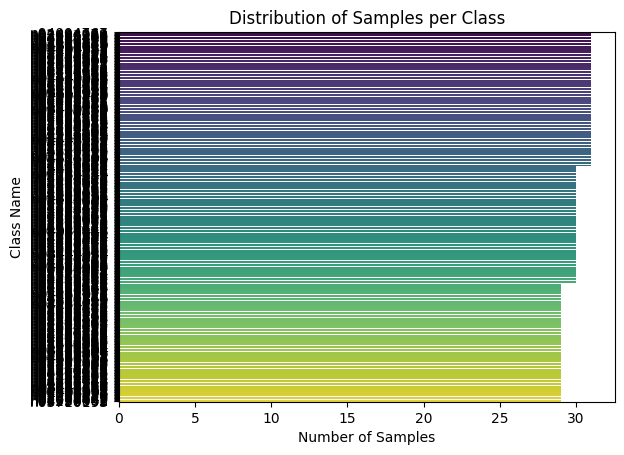

In [9]:
# class_name별로 샘플의 개수를 출력
sns.countplot(y=train_data['class_name'], order=train_data['class_name'].value_counts().index, palette='viridis')
plt.title('Distribution of Samples per Class')
plt.xlabel('Number of Samples')
plt.ylabel('Class Name')

/tmp/ipykernel_66534/2980358208.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(train_data['target'], bins=500, kde=False, palette='viridis')


Text(0, 0.5, 'Number of Samples')

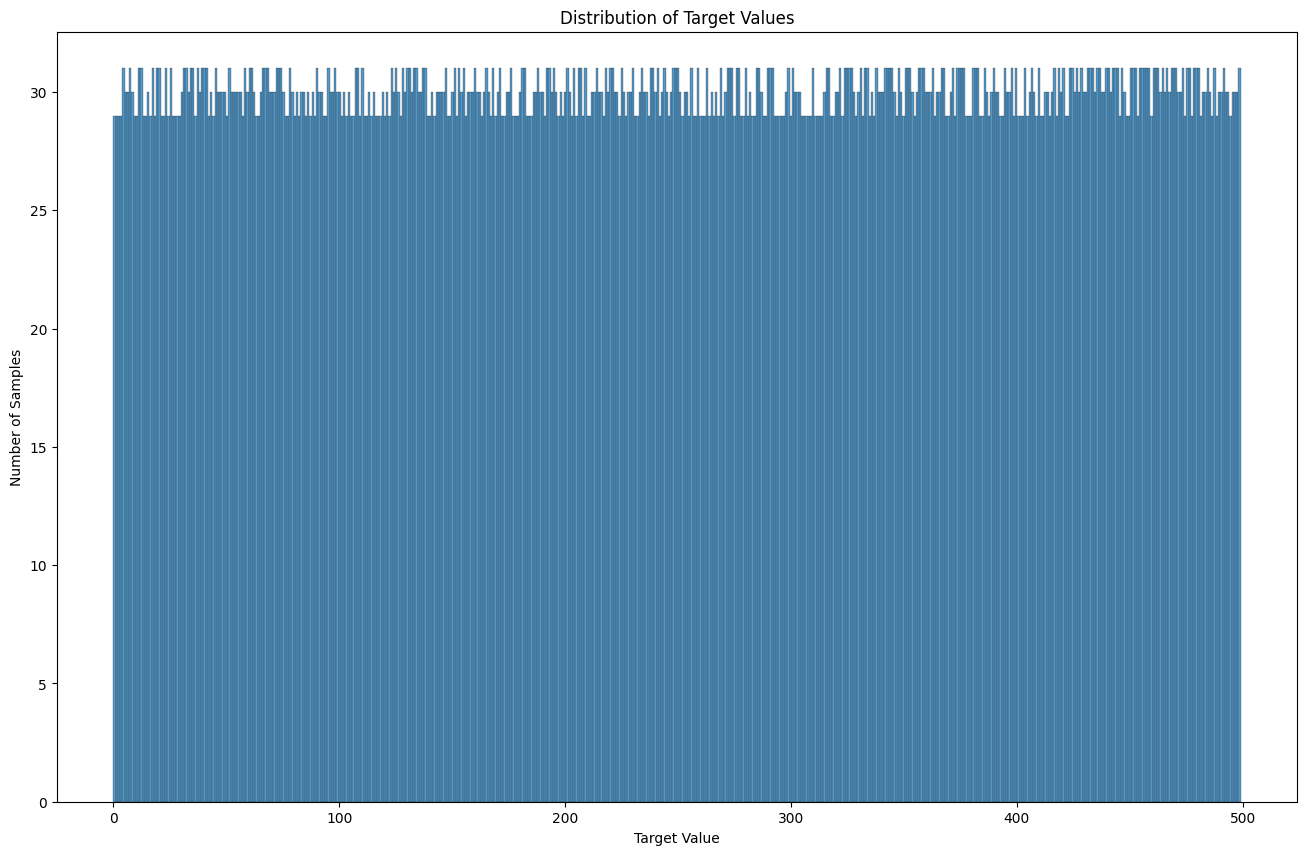

In [10]:
# target 값의 분포를 출력
plt.figure(figsize=(16, 10))
sns.histplot(train_data['target'], bins=500, kde=False, palette='viridis')
plt.title('Distribution of Target Values')
plt.xlabel('Target Value')
plt.ylabel('Number of Samples')

Class name 분포
- 대부분 29에서 31 사이의 값을 가지고 있음

Target 분포
- 대부분 29에서 31 사이의 값을 가지고 있음

데이터 셋 전반적으로 Class name, Target에 대해서 29~31개의 값을 가지고 있음.

### 이미지 데이터 불러오기

In [11]:
# glob을 이용하여 이미지 파일의 경로를 읽어옴
train_images = glob(traindata_dir + "/*/*")
test_images = glob(testdata_dir + "/*")
print(f"Number of train images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of train images: 15021
Number of test images: 10014


- image_data : 각 이미지에 대한 높이, 너비, 종횡비, 모드(컬러, 흑백), 파일 형식, 파일크기(MB), 전체 경로, 상대경로, 클래스명, 타깃값에 대한 정보가 담긴 데이터프레임
- train_image의 mode 분포 비율은 약 6 : 1

In [120]:
# 이미지의 특징을 추출하는 함수
def extract_image_features(image_path):
    """
    Extracts features from an image.
    Args:
        image_path (str): Path to the image file.
    Returns:
        width (int): Width of the image.
        height (int): Height of the image.
        mode (str): Mode of the image.
        format (str): Format of the image.
        size (int): Size of the image.
        mean_red (float): Mean of red channel.
        mean_green (float): Mean of green channel.
        mean_blue (float): Mean of blue channel.
    """
    try:
        with Image.open(image_path) as img:
            mode = img.mode  # 원래 모드를 저장
            width, height = img.size
            img_array = np.array(img)
            
            # RGB 모드인 경우만 평균값 계산
            if mode == 'RGB':
                mean_red = np.mean(img_array[:, :, 0])
                mean_green = np.mean(img_array[:, :, 1])
                mean_blue = np.mean(img_array[:, :, 2])
            else:
                mean_red = mean_green = mean_blue = None  # RGB가 아니면 None 처리
            
            format = image_path.split('.')[-1].upper()
            return width, height, mode, format, os.path.getsize(image_path), mean_red, mean_green, mean_blue
    except Exception as e:
        return None, None, None, None, None, None, None, None

image_prop = defaultdict(list) # 이미지의 속성을 저장할 딕셔너리 생성

for i, path in enumerate(train_images):
    width, height, mode, format, size, mean_red, mean_green, mean_blue = extract_image_features(path)
    image_prop['height'].append(height)
    image_prop['width'].append(width)
    image_prop['mode'].append(mode)
    image_prop['format'].append(format)
    image_prop['size'].append(round(size / 1e6, 2) if size else None)
    image_prop['mean_red'].append(mean_red)
    image_prop['mean_green'].append(mean_green)
    image_prop['mean_blue'].append(mean_blue)
    image_prop['path'].append(path)
    image_prop['image_path'].append(path.split('/')[-2] + "/" + path.split('/')[-1])

image_data = pd.DataFrame(image_prop)
image_data['img_aspect_ratio'] = image_data['width'] / image_data['height'] # aspect_ratio = 종횡비 즉, 이미지의 가로 세로 비율

image_data = image_data.merge(train_data, on='image_path')
image_data.sort_values(by='target', inplace=True)
image_data.head()


height  width mode format  size    mean_red  mean_green   mean_blue  \
4085     800    800    L   JPEG  0.05         NaN         NaN         NaN   
4099     800    800  RGB   JPEG  0.08  237.486839  236.766581  237.353262   
4098     590    678  RGB   JPEG  0.12  223.690230  223.698965  223.685376   
4101     800    800  RGB   JPEG  0.08  231.976581  231.976581  231.976581   
4100     250    238  RGB   JPEG  0.02  244.810504  244.756134  244.456252   

                                       path                image_path  \
4085  ./data/train/n01443537/sketch_35.JPEG  n01443537/sketch_35.JPEG   
4099  ./data/train/n01443537/sketch_34.JPEG  n01443537/sketch_34.JPEG   
4098  ./data/train/n01443537/sketch_11.JPEG  n01443537/sketch_11.JPEG   
4101  ./data/train/n01443537/sketch_42.JPEG  n01443537/sketch_42.JPEG   
4100   ./data/train/n01443537/sketch_4.JPEG   n01443537/sketch_4.JPEG   

      img_aspect_ratio class_name  target  
4085          1.000000  n01443537       0  
4099          1.000000  n01443537       0  
4098          1.149153  n01443537       0  
4101          1.000000  n01443537       0  
4100          0.952000  n01443537       0

In [121]:
image_data['mode'].value_counts() 

mode
RGB    12443
L       2578
Name: count, dtype: int64

In [18]:
image_data['target'].value_counts().sort_index()

target
0      29
1      29
2      29
3      29
4      31
       ..
495    29
496    30
497    30
498    30
499    31
Name: count, Length: 500, dtype: int64

### 종횡비 이상치 분석

In [122]:
image_data['img_aspect_ratio'].describe()

count    15021.000000
mean         1.076926
std          0.319188
min          0.287500
25%          0.906667
50%          1.000000
75%          1.260504
max          3.703704
Name: img_aspect_ratio, dtype: float64

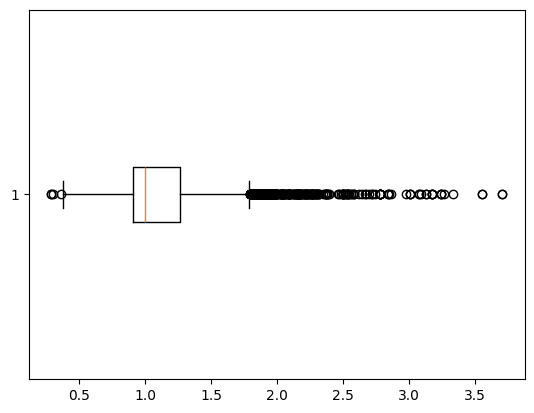

In [123]:
plt.boxplot(image_data['img_aspect_ratio'], vert=False)
plt.show()

In [142]:
ratio_outlier = image_data.sort_values(by='img_aspect_ratio', ascending=False).head(10)
ratio_outlier

height  width mode format  size    mean_red  mean_green   mean_blue  \
661       216    800  RGB   JPEG  0.03  233.290480  233.349589  231.891354   
3715      216    800  RGB   JPEG  0.02  234.440596  234.440596  234.440596   
8100      225    800  RGB   JPEG  0.02  236.132228  236.132228  236.132228   
8105      225    800  RGB   JPEG  0.02  236.132906  236.132906  236.132906   
2256      240    800  RGB   JPEG  0.04  208.762833  208.276021  208.506714   
10890     245    800  RGB   JPEG  0.03  228.207791  228.170474  228.216194   
1748      247    800  RGB   JPEG  0.04  217.143634  217.143634  217.143634   
1746      247    800  RGB   JPEG  0.04  217.153047  217.153047  217.153047   
1755      247    800  RGB   JPEG  0.04  217.152454  217.152454  217.152454   
6814      252    800    L   JPEG  0.03         NaN         NaN         NaN   

                                        path                image_path  \
661    ./data/train/n02749479/sketch_43.JPEG  n02749479/sketch_43.JPEG   
3715   ./data/train/n04487394/sketch_25.JPEG  n04487394/sketch_25.JPEG   
8100   ./data/train/n01855032/sketch_20.JPEG  n01855032/sketch_20.JPEG   
8105   ./data/train/n01855032/sketch_48.JPEG  n01855032/sketch_48.JPEG   
2256   ./data/train/n04366367/sketch_21.JPEG  n04366367/sketch_21.JPEG   
10890  ./data/train/n04336792/sketch_19.JPEG  n04336792/sketch_19.JPEG   
1748   ./data/train/n03956157/sketch_46.JPEG  n03956157/sketch_46.JPEG   
1746    ./data/train/n03956157/sketch_8.JPEG   n03956157/sketch_8.JPEG   
1755   ./data/train/n03956157/sketch_27.JPEG  n03956157/sketch_27.JPEG   
6814   ./data/train/n01735189/sketch_18.JPEG  n01735189/sketch_18.JPEG   

       img_aspect_ratio class_name  target  
661            3.703704  n02749479     232  
3715           3.703704  n04487394     431  
8100           3.555556  n01855032      56  
8105           3.555556  n01855032      56  
2256           3.333333  n04366367     406  
10890          3.265306  n04336792     399  
1748           3.238866  n03956157     342  
1746           3.238866  n03956157     342  
1755           3.238866  n03956157     342  
6814           3.174603  n01735189      33

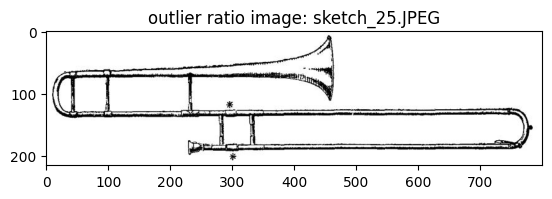

In [143]:
outlier_ratio_img_path = ratio_outlier.iloc[1, 8]

img = Image.open(outlier_ratio_img_path)
plt.title(f"outlier ratio image: {outlier_ratio_img_path.split('/')[-1]}")
plt.imshow(img)

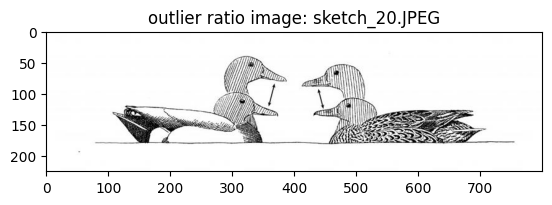

In [144]:
outlier_ratio_img_path = ratio_outlier.iloc[2, 8]

img = Image.open(outlier_ratio_img_path)
plt.title(f"outlier ratio image: {outlier_ratio_img_path.split('/')[-1]}")
plt.imshow(img)

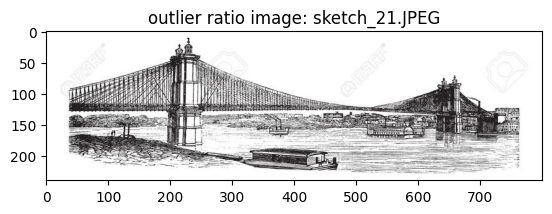

In [145]:
outlier_ratio_img_path = ratio_outlier.iloc[4, 8]

img = Image.open(outlier_ratio_img_path)
plt.title(f"outlier ratio image: {outlier_ratio_img_path.split('/')[-1]}")
plt.imshow(img)

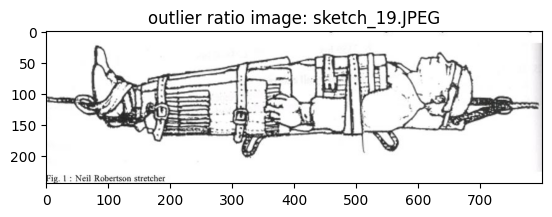

In [146]:
outlier_ratio_img_path = ratio_outlier.iloc[5, 8]

img = Image.open(outlier_ratio_img_path)
plt.title(f"outlier ratio image: {outlier_ratio_img_path.split('/')[-1]}")
plt.imshow(img)

In [148]:
ratio_outlier.iloc[6]

height                                                247
width                                                 800
mode                                                  RGB
format                                               JPEG
size                                                 0.04
mean_red                                       217.143634
mean_green                                     217.143634
mean_blue                                      217.143634
path                ./data/train/n03956157/sketch_46.JPEG
image_path                       n03956157/sketch_46.JPEG
img_aspect_ratio                                 3.238866
class_name                                      n03956157
target                                                342
Name: 1748, dtype: object

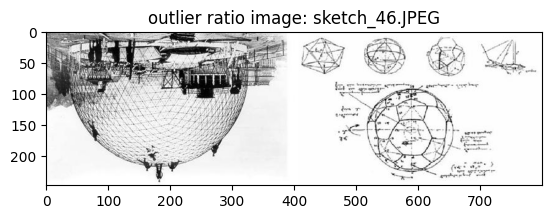

In [147]:
outlier_ratio_img_path = ratio_outlier.iloc[6, 8]

img = Image.open(outlier_ratio_img_path)
plt.title(f"outlier ratio image: {outlier_ratio_img_path.split('/')[-1]}")
plt.imshow(img)

### 이미지 파일 크기 분석

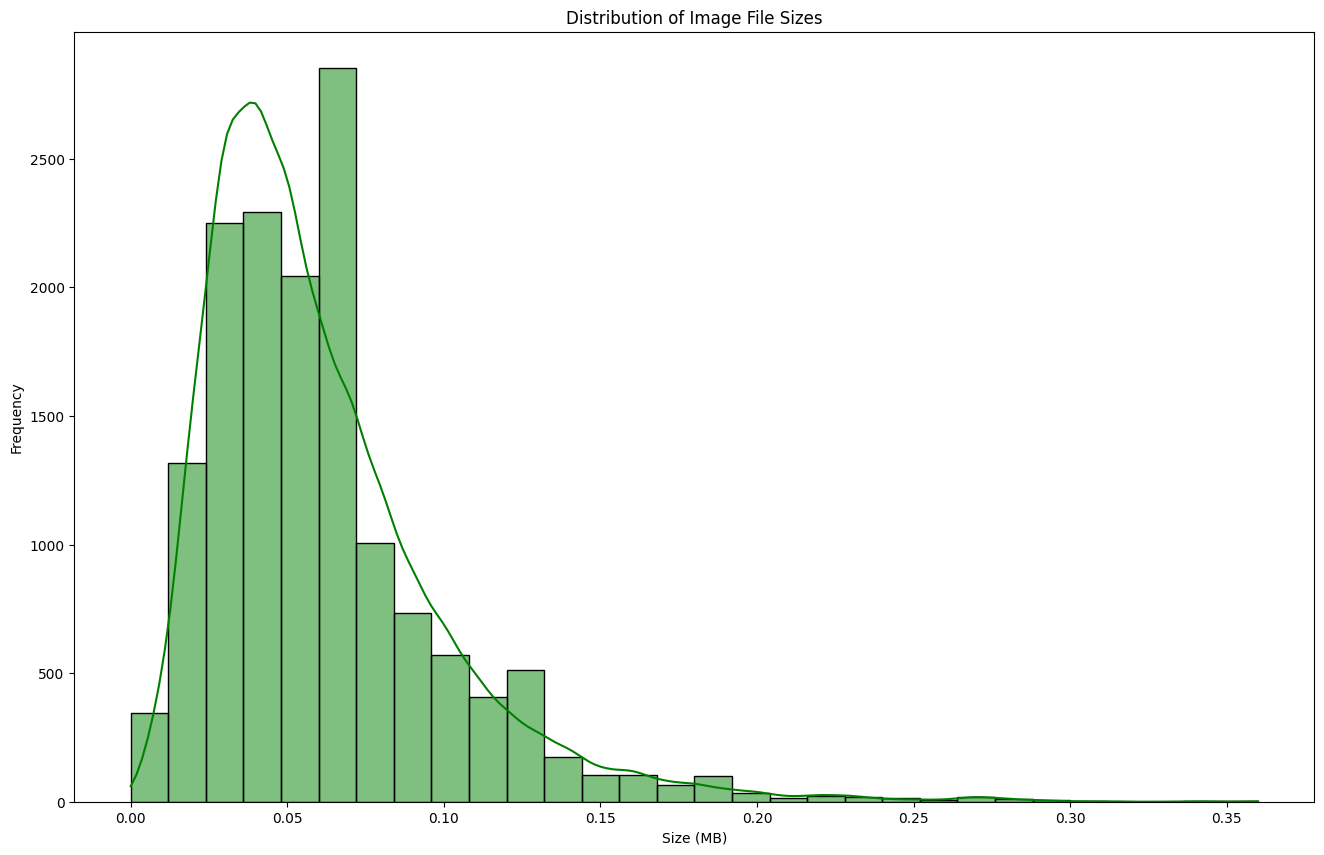

In [19]:
plt.figure(figsize=(16, 10))

# 이미지 파일의 크기 분포를 출력
sns.histplot(image_data['size'], bins=30, kde=True, color='green')
plt.title('Distribution of Image File Sizes')
plt.xlabel('Size (MB)')
plt.ylabel('Frequency')

plt.show()

이미지 파일 크기 분포
- 대부분 이미지 파일 크기는 0.05 ~ 0.1 MB 사이에 분포

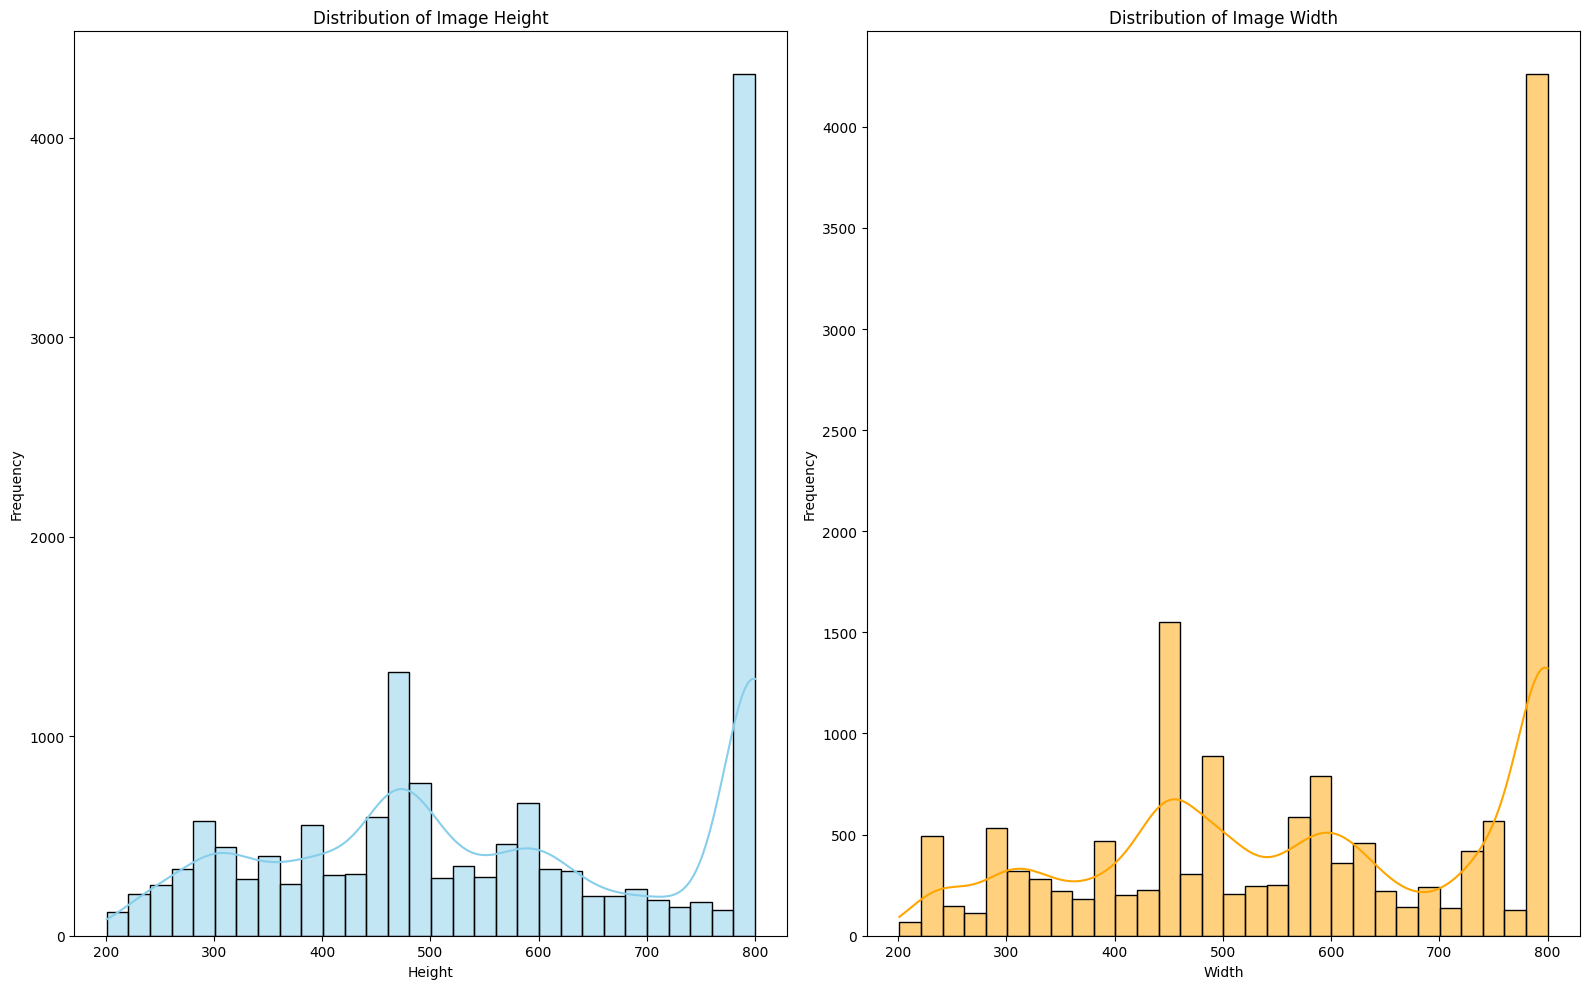

In [20]:
plt.figure(figsize=(16, 10))
# Image height의 분포를 출력
plt.subplot(1, 2, 1)
sns.histplot(image_data['height'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.ylabel('Frequency')

# Image width의 분포를 출력
plt.subplot(1, 2, 2)
sns.histplot(image_data['width'], bins=30, kde=True, color='orange')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

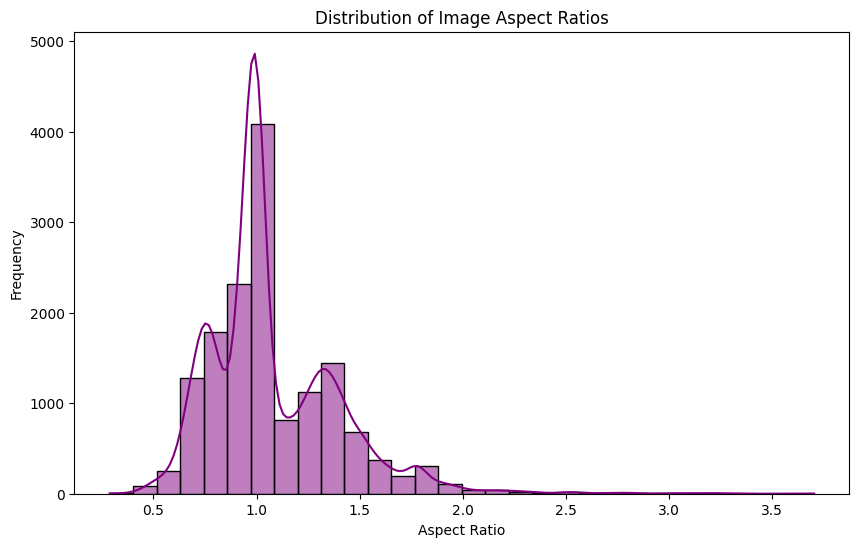

In [21]:
plt.figure(figsize=(10, 6))

# 이미지의 가로 세로 비율을 출력
sns.histplot(image_data['img_aspect_ratio'], bins=30, kde=True, color='purple')
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')

plt.show()


- 가로세로 비율 = 0.8 ~ 1.2 사이 분포

In [22]:
# 10개의 샘플 선택
sample_classes = image_data['class_name'].unique()[:10]

# 각 클래스별로 RGB값의 평균을 계산
mean_rgb_per_class = image_data[image_data['class_name'].isin(sample_classes)].groupby('class_name')[['mean_red', 'mean_green', 'mean_blue']].mean()

# 클래스별로 RGB값의 평균을 출력
mean_rgb_per_class.plot(kind='bar', figsize=(16, 10), color=['red', 'green', 'blue'])
plt.title('Mean RGB Values per Class')
plt.xlabel('Class Name')
plt.ylabel('Mean RGB Value')
plt.xticks(rotation=45)
plt.legend(['Mean Red', 'Mean Green', 'Mean Blue'])
plt.show()


KeyError: "Columns not found: 'mean_green', 'mean_red', 'mean_blue'"

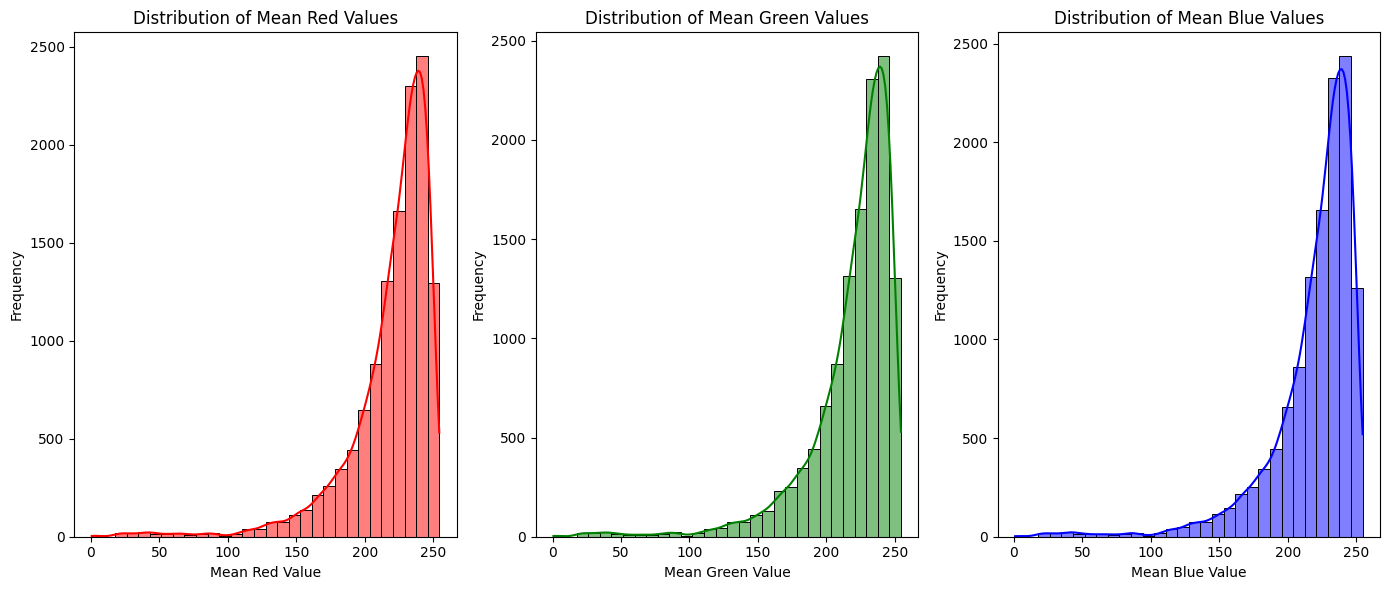

In [125]:
# RGB값의 평균 분포를 출력
plt.figure(figsize=(14, 6))

# mean_red 값의 분포를 출력
plt.subplot(1, 3, 1)
sns.histplot(image_data['mean_red'], bins=30, kde=True, color='red')
plt.title('Distribution of Mean Red Values')
plt.xlabel('Mean Red Value')
plt.ylabel('Frequency')

# mean_green 값의 분포를 출력
plt.subplot(1, 3, 2)
sns.histplot(image_data['mean_green'], bins=30, kde=True, color='green')
plt.title('Distribution of Mean Green Values')
plt.xlabel('Mean Green Value')
plt.ylabel('Frequency')

# mean_blue 값의 분포를 출력
plt.subplot(1, 3, 3)
sns.histplot(image_data['mean_blue'], bins=30, kde=True, color='blue')
plt.title('Distribution of Mean Blue Values')
plt.xlabel('Mean Blue Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


색상 분포 분석
- 대부분 Red, Green, Blue값이 200~250사이에 분포
- 전반적으로 이미지의 밝기와 채도가 높은 편

C:\Users\User\AppData\Local\Temp\ipykernel_9640\2640141684.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='height', y='class_name', data=class_size_stats.sort_values(by='height', ascending=False), palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_9640\2640141684.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='width', y='class_name', data=class_size_stats.sort_values(by='width', ascending=False), palette='viridis')


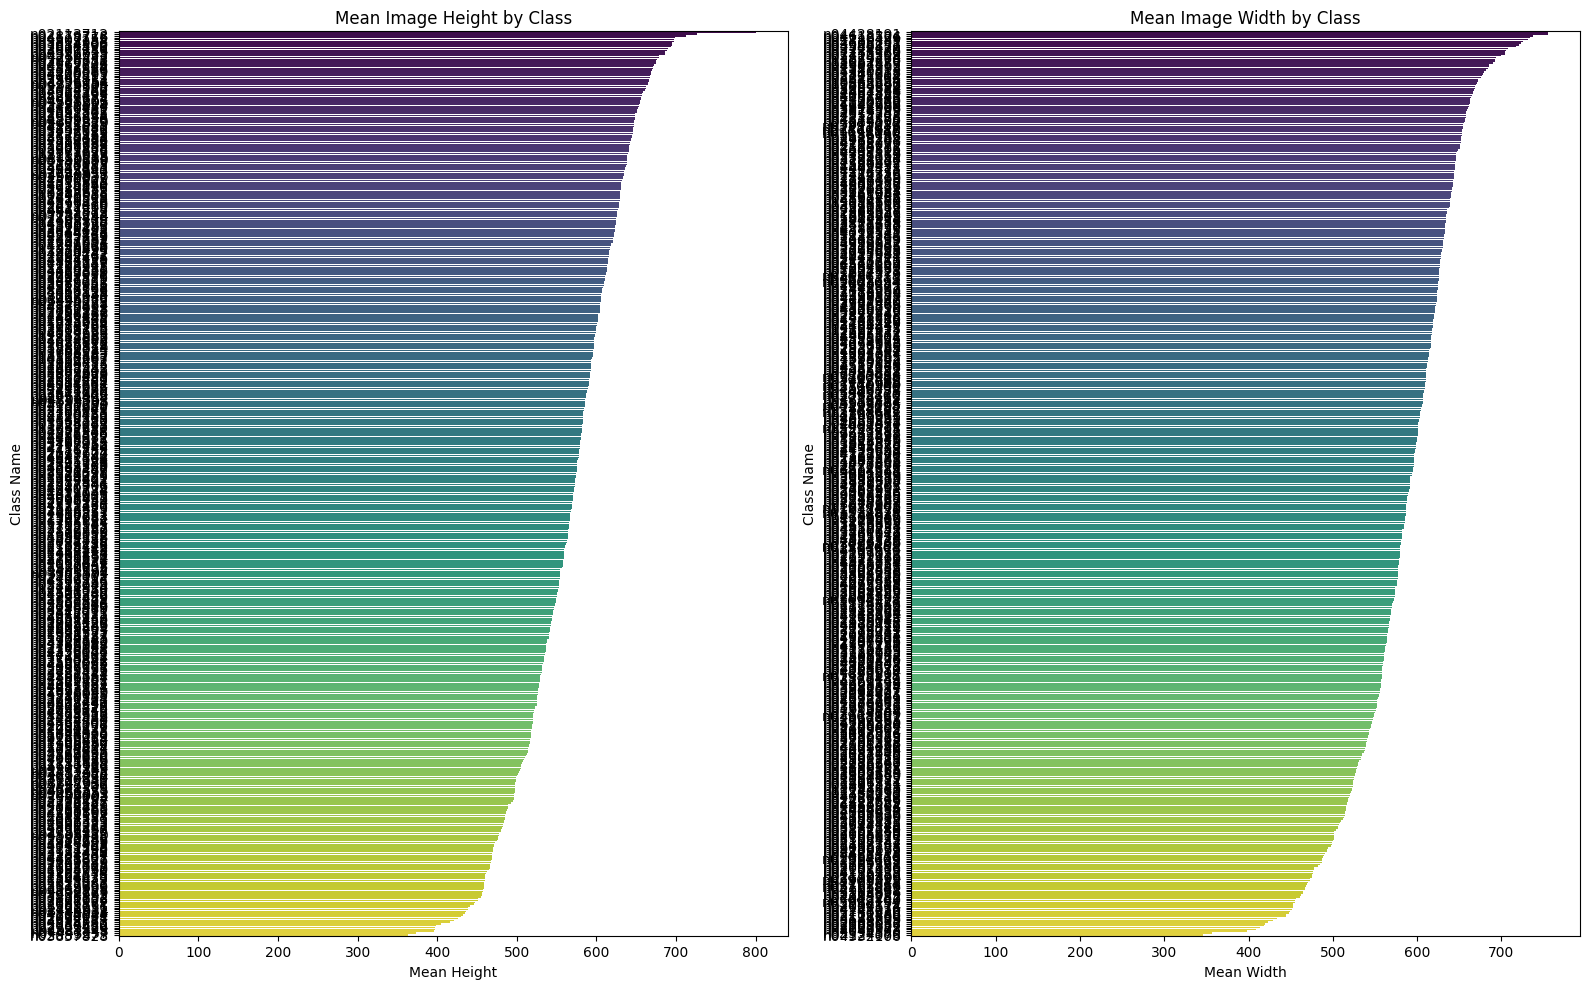

In [126]:
# 각 클래스별로 이미지의 평균 높이와 너비를 계산
class_size_stats = image_data.groupby('class_name')[['height', 'width']].mean().reset_index()

# 각 클래스별로 이미지의 평균 높이와 너비를 출력
plt.figure(figsize=(16, 10))

# 클래스별 이미지의 평균 높이를 출력
plt.subplot(1, 2, 1)
sns.barplot(x='height', y='class_name', data=class_size_stats.sort_values(by='height', ascending=False), palette='viridis')
plt.title('Mean Image Height by Class')
plt.xlabel('Mean Height')
plt.ylabel('Class Name')

# 클래스별 이미지의 평균 너비를 출력
plt.subplot(1, 2, 2)
sns.barplot(x='width', y='class_name', data=class_size_stats.sort_values(by='width', ascending=False), palette='viridis')
plt.title('Mean Image Width by Class')
plt.xlabel('Mean Width')
plt.ylabel('Class Name')

plt.tight_layout()
plt.show()

클래스별 이미지 크기 분포
- 대부분 클래스는 300에서 800 픽셀 사이의 평균 높이를 가지고 있음
- 대부분 클래스느 300에서 800 픽셀 사이의 평균 너비를 가지고 있음

ValueError: Could not interpret value `mean_red` for `y`. An entry with this name does not appear in `data`.

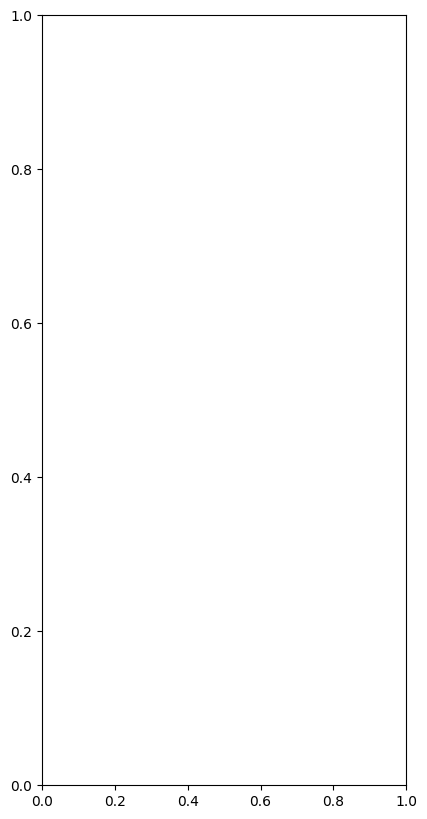

In [23]:
plt.figure(figsize=(16, 10))

# mean_red 값의 분포를 출력
plt.subplot(1, 3, 1)
sns.boxplot(x='target', y='mean_red', data=image_data, palette='Reds')
plt.title('Mean Red Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Red Value')
plt.xticks(rotation=90)

# mean_green 값의 분포를 출력
plt.subplot(1, 3, 2)
sns.boxplot(x='target', y='mean_green', data=image_data, palette='Greens')
plt.title('Mean Green Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Green Value')
plt.xticks(rotation=90)

# mean_blue 값의 분포를 출력
plt.subplot(1, 3, 3)
sns.boxplot(x='target', y='mean_blue', data=image_data, palette='Blues')
plt.title('Mean Blue Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Blue Value')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


클래스별 이미지 색상의 분포
- 대부분 Red, Green, Blue 값은 200에서 250 사이에 분포

### 이미지 출력해보기

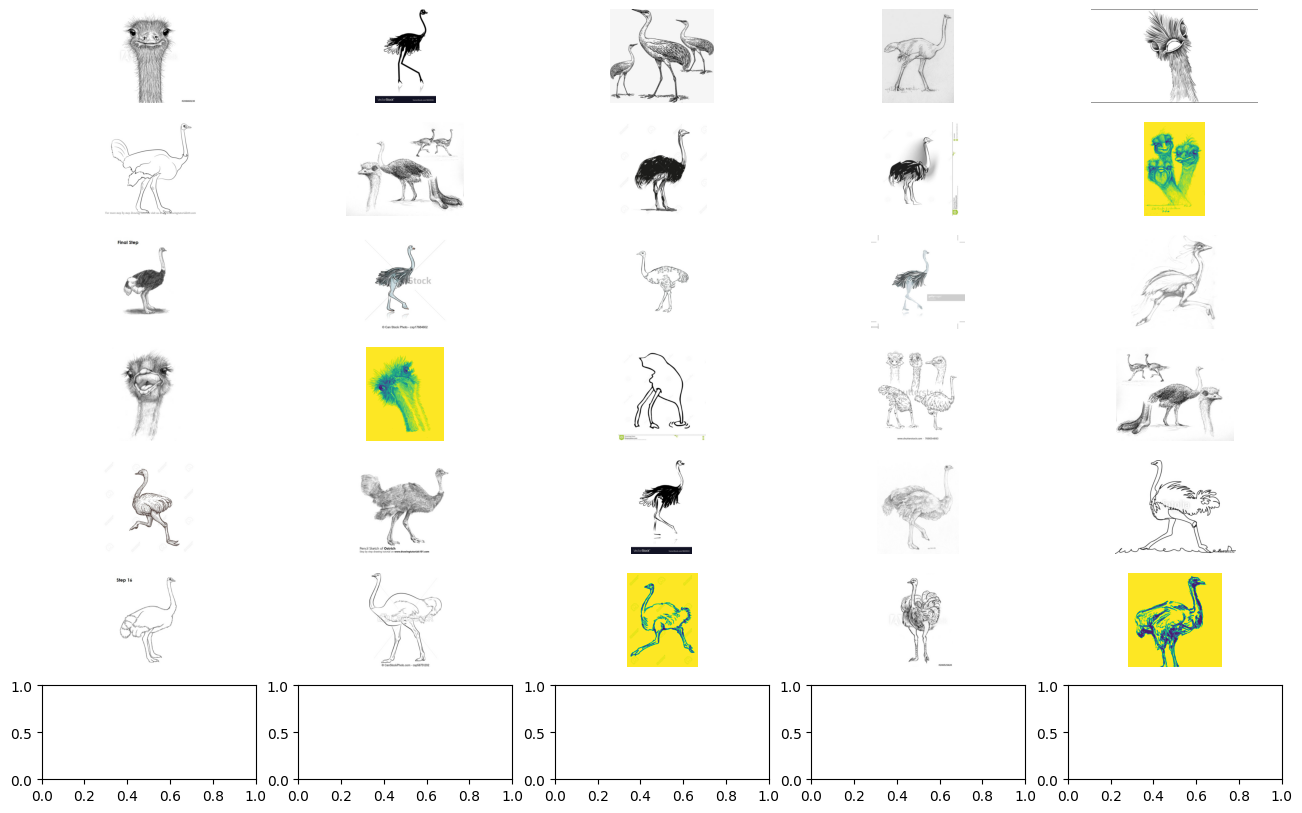

In [128]:
# 같은 target을 가진 이미지 전체 출력
def display_images(data, target):
    len_data = len(data[data['target'] == target])
    fig, axs = plt.subplots((len_data // 5)+1, 5, figsize=(16, 10))
    images = data[data['target'] == target]['path'].values
    for i, path in enumerate(images):
        img = Image.open(path)
        ax = axs[i // 5, i % 5]  # Use double indexing for 2D subplots
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# target이 0인 이미지 출력
display_images(image_data, target=5)

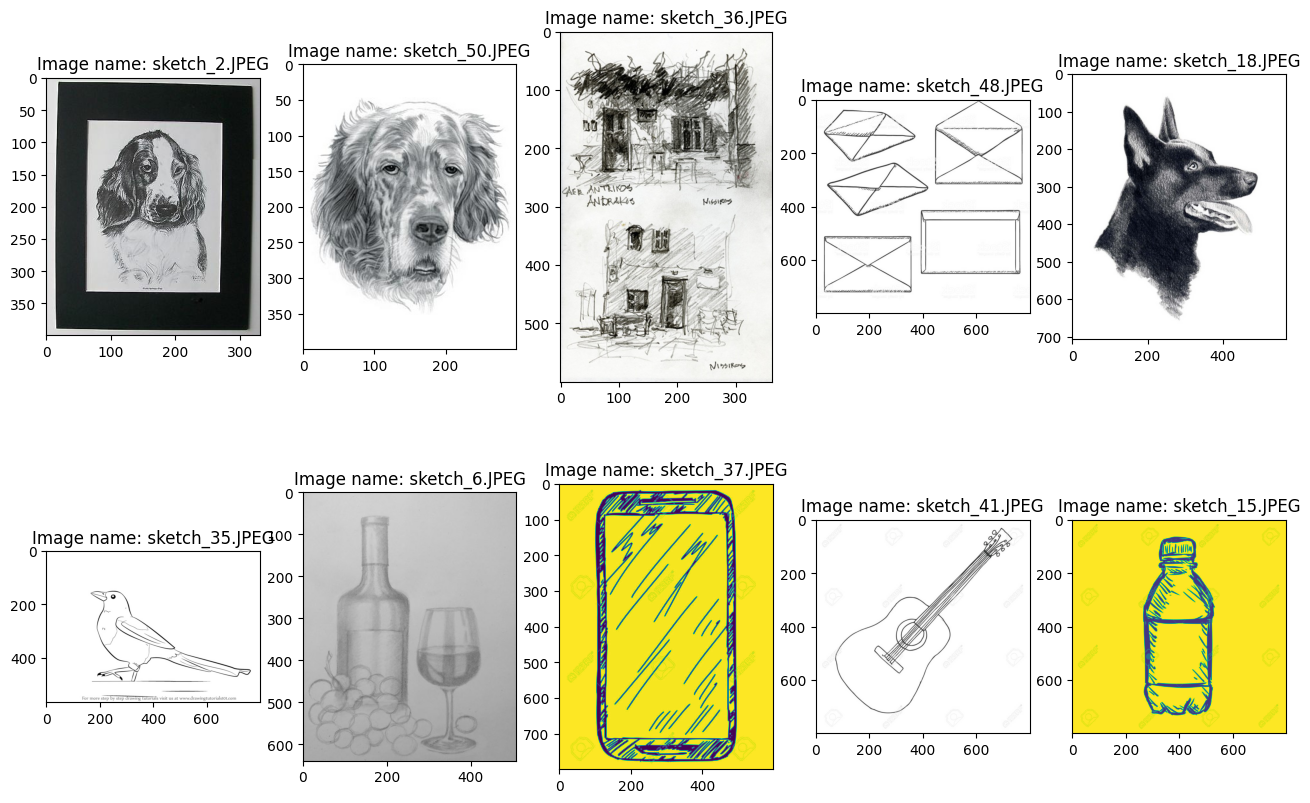

In [24]:
# 이미지를 랜덤으로 5개 출력
plt.style.use('default')
fig, axex = plt.subplots(2, 5, figsize=(16, 10))
for ax in axex.reshape(-1):
    img_path = np.random.choice(train_images)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Image name: {img_path.split('/')[-1]}")
plt.show()

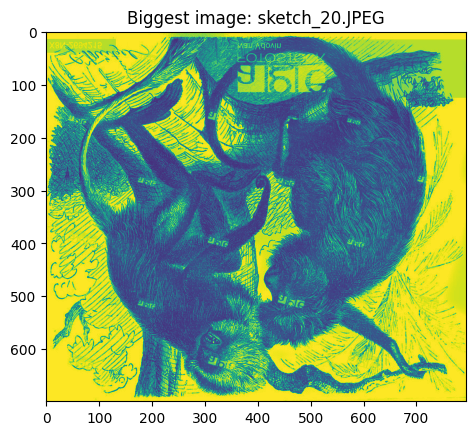

In [25]:
# 가장 큰 이미지를 출력
biggest_img_path = image_data.iloc[image_data['size'].idxmax(),:]['path']

img = Image.open(biggest_img_path)
plt.title(f"Biggest image: {biggest_img_path.split('/')[-1]}")
plt.imshow(img)
del img

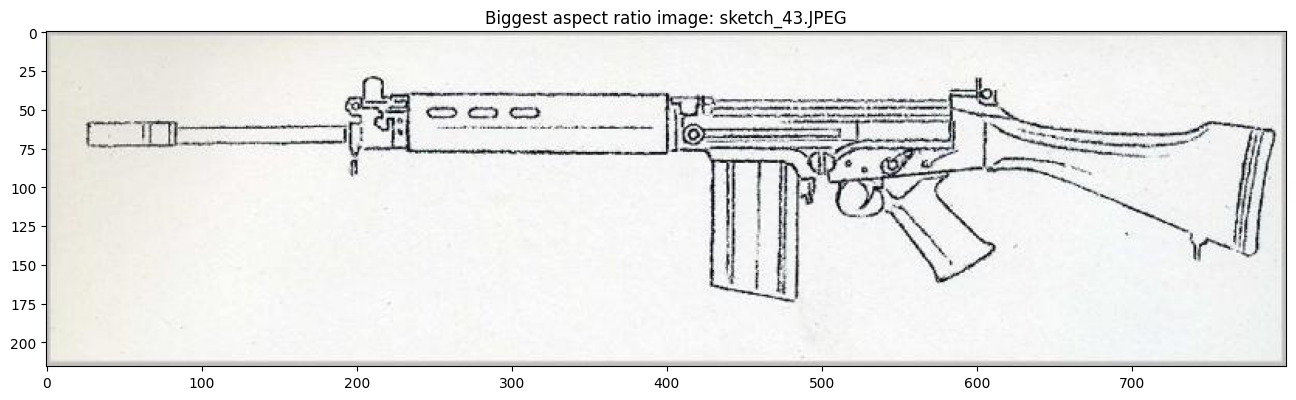

In [26]:
# 이미지의 종횡비가 가장 큰 이미지를 출력
biggest_aspect_ratio_img_path = image_data.iloc[image_data['img_aspect_ratio'].idxmax(),:]['path']

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
img = Image.open(biggest_aspect_ratio_img_path)
plt.title(f"Biggest aspect ratio image: {biggest_aspect_ratio_img_path.split('/')[-1]}")
plt.imshow(img)

In [27]:
# 4개의 작은 이미지를 출력
smallest_img_paths = image_data.nsmallest(4, 'size')['path']
smallest_img_paths.values

array(['./data/train/n04127249/sketch_9.JPEG',
       './data/train/n04026417/sketch_32.JPEG',
       './data/train/n02105056/sketch_0.JPEG',
       './data/train/n02105056/sketch_47.JPEG'], dtype=object)

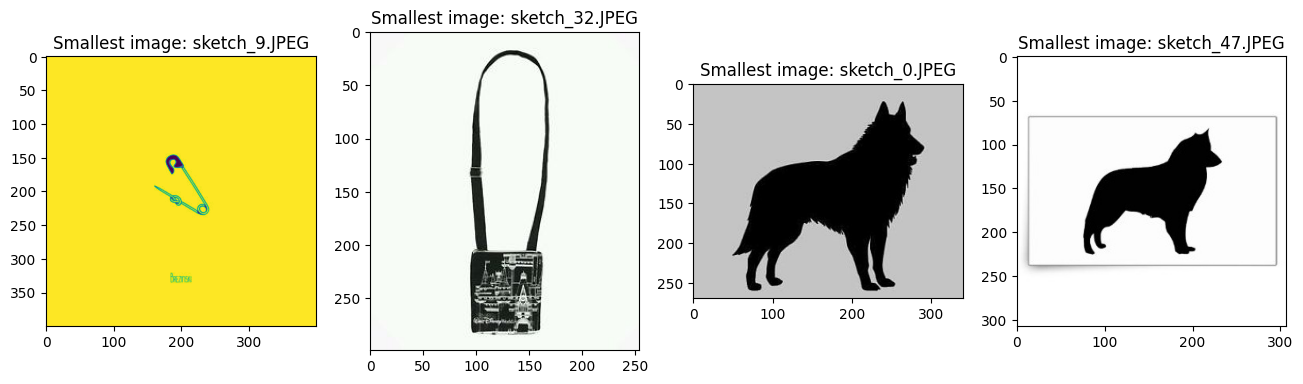

In [28]:
import matplotlib.image as mpimg

# 4개의 작은 이미지를 출력
fig, axes = plt.subplots(1, 4, figsize=(16, 10))
for i, ax in enumerate(axes.reshape(-1)):
    img = mpimg.imread(smallest_img_paths.values[i])
    ax.title.set_text(f"Smallest image: {smallest_img_paths.values[i].split('/')[-1]}")
    ax.imshow(img)
plt.show()

### cv2 활용해서 이미지 분석하기

In [100]:
img_path = train_images[29]
selected_img = image_data[image_data['path'] == img_path]
selected_img

height  width  img_aspect_ratio mode format  size  \
29     800    800               1.0  RGB   JPEG   0.1   

                                     path                image_path  \
29  ./data/train/n04039381/sketch_49.JPEG  n04039381/sketch_49.JPEG   

   class_name  target  
29  n04039381     357

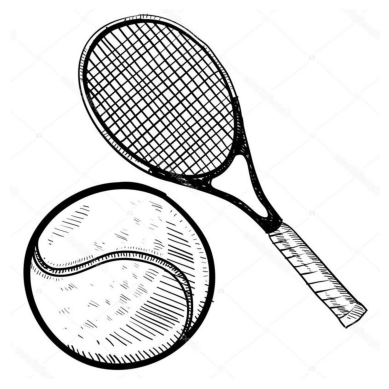

In [101]:
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

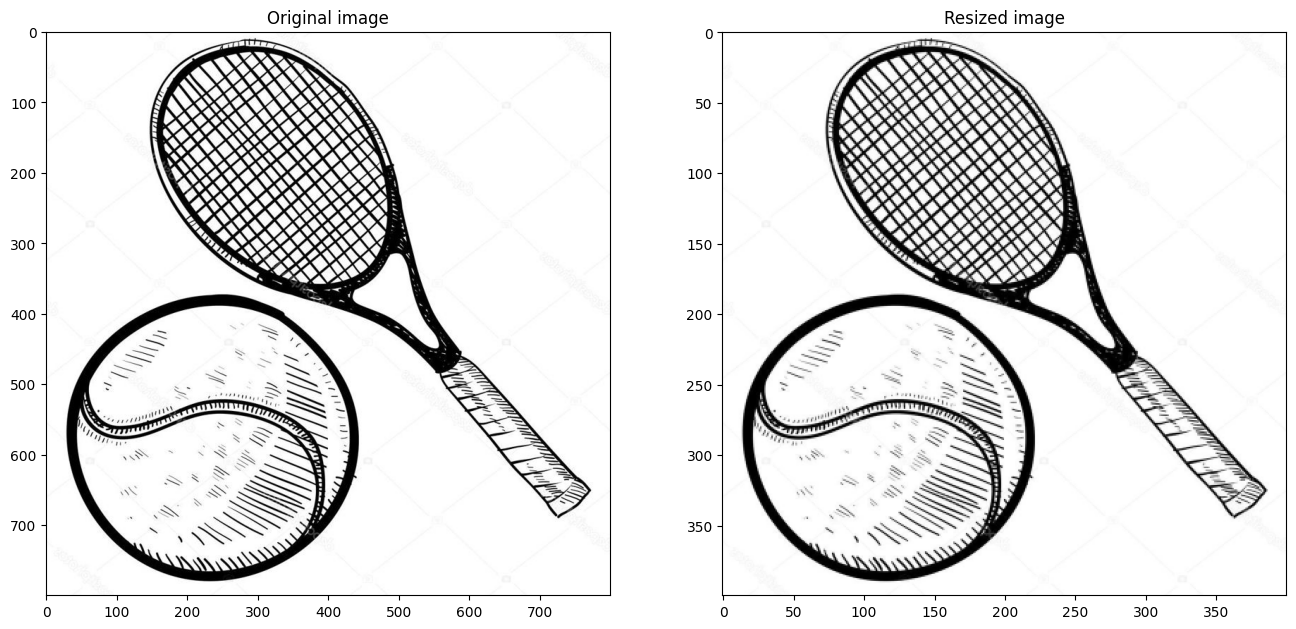

In [102]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
resized_img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].imshow(img)
ax[0].set_title("Original image")
ax[1].imshow(resized_img)
ax[1].set_title("Resized image")
plt.show()

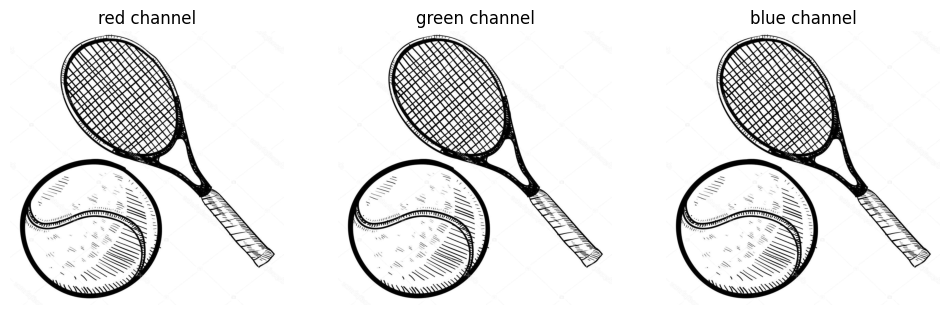

In [103]:
fig, axes = plt.subplots(1,3, figsize=(12,12))
colors = ['red', 'green', 'blue']
for i, ax in enumerate(axes):
    ax.imshow(img[:,:,i], cmap='gray')
    ax.set_title(colors[i]+' channel'), ax.axis('off')
plt.show()

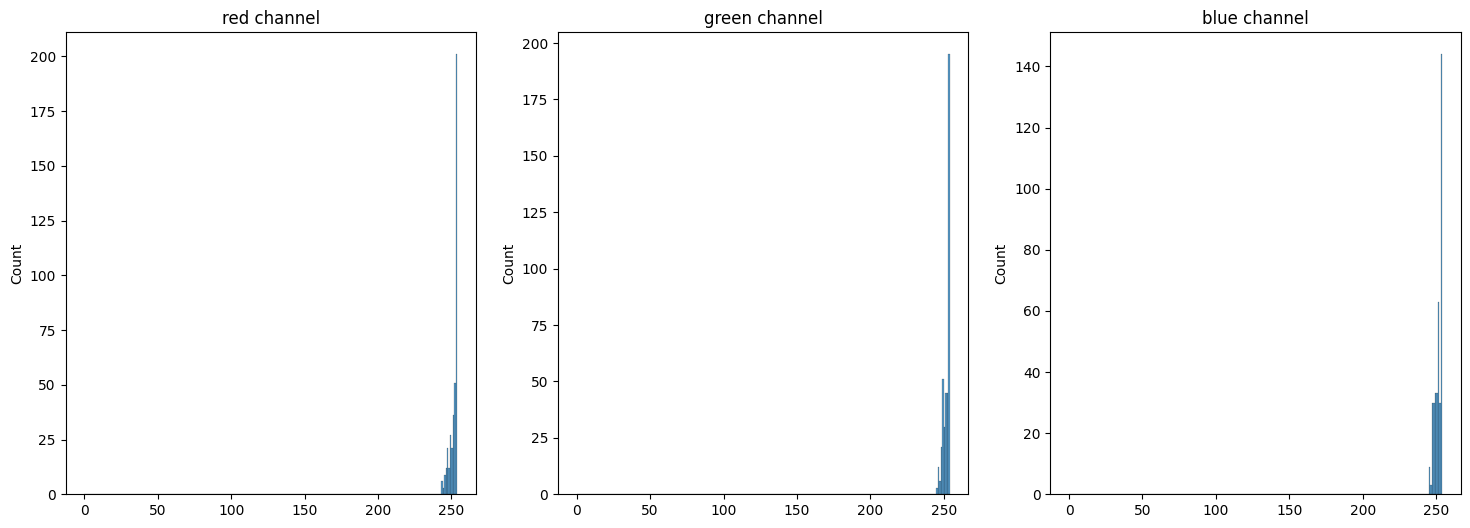

In [104]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
for i, ax in enumerate(axes):
    df = img[i].ravel()
    sns.histplot(df, bins=np.arange(0,255), ax=ax)
    ax.set_title(colors[i]+' channel')
plt.show()

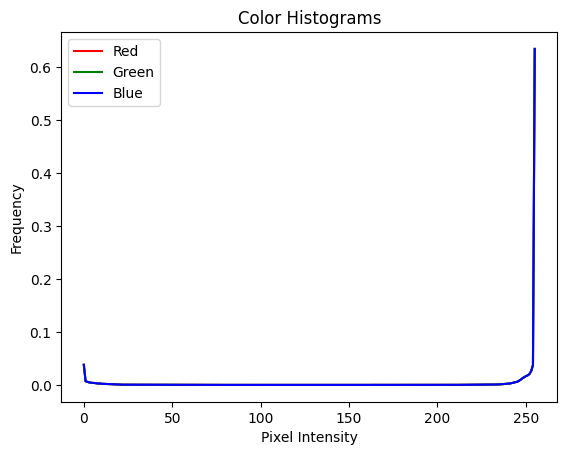

In [105]:
# Compute color histograms for each channel
hist_red, bins_red = np.histogram(img[:, :, 0], bins=256, range=(0, 256), density=True)
hist_green, bins_green = np.histogram(img[:, :, 1], bins=256, range=(0, 256), density=True)
hist_blue, bins_blue = np.histogram(img[:, :, 2], bins=256, range=(0, 256), density=True)

# Plot color histograms
plt.plot(bins_red[:-1], hist_red, color='red', label='Red')
plt.plot(bins_green[:-1], hist_green, color='green', label='Green')
plt.plot(bins_blue[:-1], hist_blue, color='blue', label='Blue')
plt.title('Color Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show() 

In [106]:
height, width, channels = img.shape
print(f"Image Height:", height)
print(f"Image Width:", width) 
print(f"Image Channels:", channels)
print(f"Image Shape: {height} x {width} x {channels}")

Image Height: 800
Image Width: 800
Image Channels: 3
Image Shape: 800 x 800 x 3


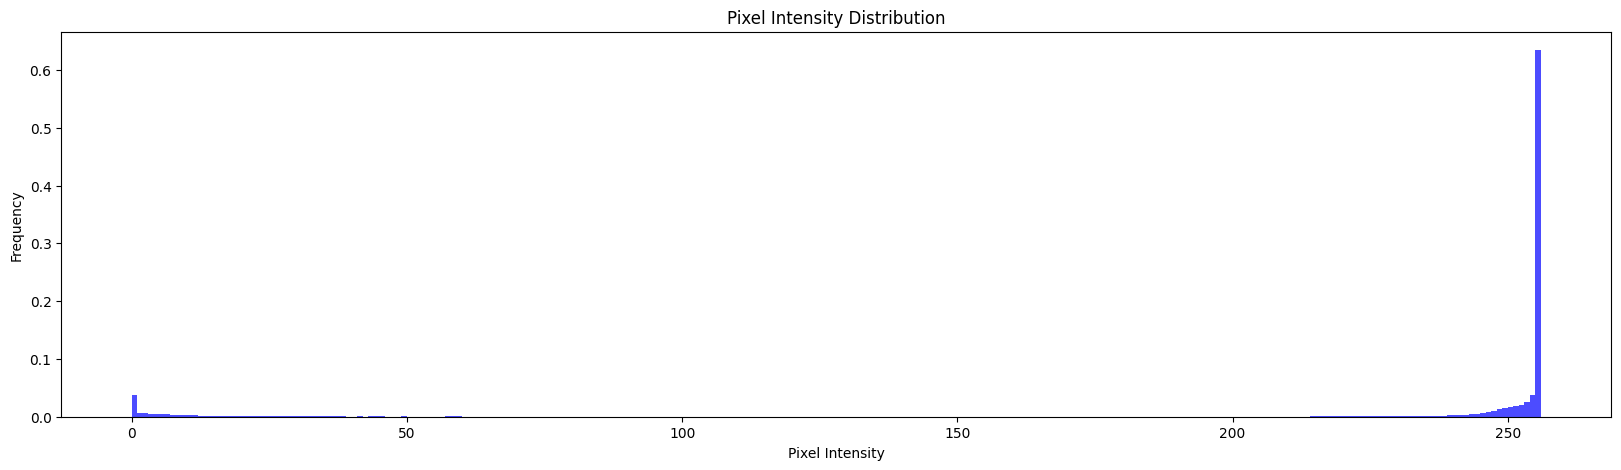

In [107]:
# pixel intensity의 분포 출력
plt.figure(figsize = (20, 5))
plt.hist(img.flatten(), bins=256, range=(0, 256), density=True, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show() 

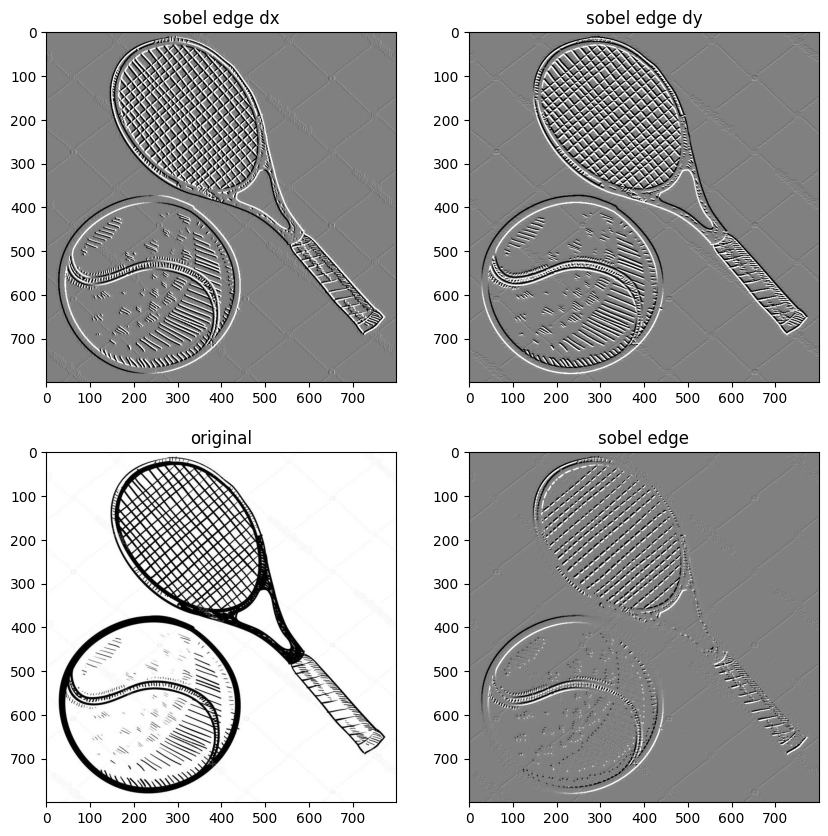

In [108]:
# 소벨 엣지 추출

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

dx = cv2.Sobel(gray_img, -1, 1, 0, delta=128)  # depth, dx, dy 순
dy = cv2.Sobel(gray_img, -1, 0, 1, delta=128)

absX = cv2.convertScaleAbs(dx)
absY = cv2.convertScaleAbs(dy)
output_img = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)

plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
plt.title('sobel edge dx')
plt.imshow(dx, cmap='gray')

plt.subplot(2,2,2)
plt.title('sobel edge dy')
plt.imshow(dy, cmap='gray')

plt.subplot(2,2,3)
plt.title('original')
plt.imshow(img, cmap='gray')

plt.subplot(2,2,4)
plt.title('sobel edge')
plt.imshow(output_img, cmap='gray')


plt.show()

In [52]:
!pip install scikit-image

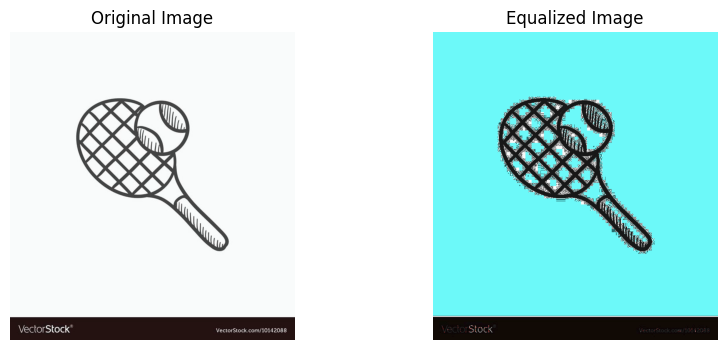

In [74]:
from skimage import exposure

# Apply histogram equalization
img_eq = exposure.equalize_hist(img)

# Display original and equalized images
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img_eq, )
axes[1].set_title('Equalized Image')
axes[1].axis('off')

plt.show()

- Image HIstogram Equalization
    - 이미지의 밝기 값에 대한 히스토그램을 계산한 후, 픽셀 값의 분포를 넓혀 전체 범위에 균등하게 분포되도록 함으로써 이미지의 어두운 부분과 밝은 부분의 디테일을 향상시켜주는 방식

배경 색이 다른 이미지도 분석해보기

In [79]:
img_path = train_images[16]
selected_img = image_data[image_data['path'] == img_path]
selected_img

height  width  img_aspect_ratio mode format  size  \
16     800    700             0.875    L   JPEG  0.06   

                                     path                image_path  \
16  ./data/train/n04039381/sketch_37.JPEG  n04039381/sketch_37.JPEG   

   class_name  target  
16  n04039381     357

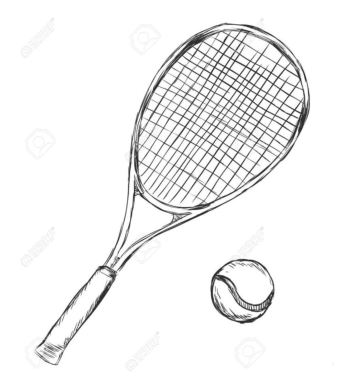

In [81]:
img = mpimg.imread(img_path)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [82]:
image_data['mode'].value_counts()

mode
RGB    12443
L       2578
Name: count, dtype: int64

- 배경 색이 존재하는 이미지의 mode는 L(흑백)
    - 배경 색이 존재하는 이미지를 이상치로 삼기엔 너무 많음.

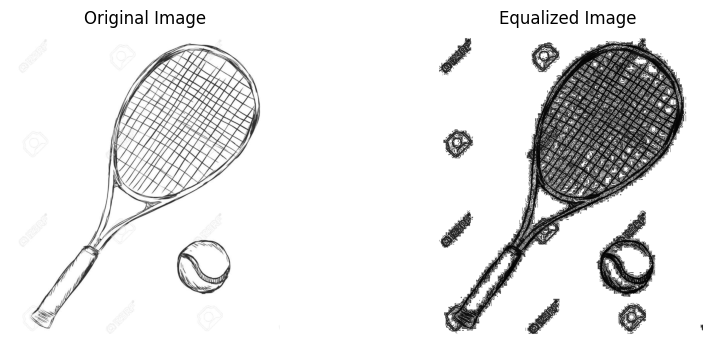

In [84]:
from skimage import exposure

# Apply histogram equalization
img_eq = exposure.equalize_hist(img)

# Display original and equalized images
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img_eq, cmap='gray')
axes[1].set_title('Equalized Image')
axes[1].axis('off')

plt.show()

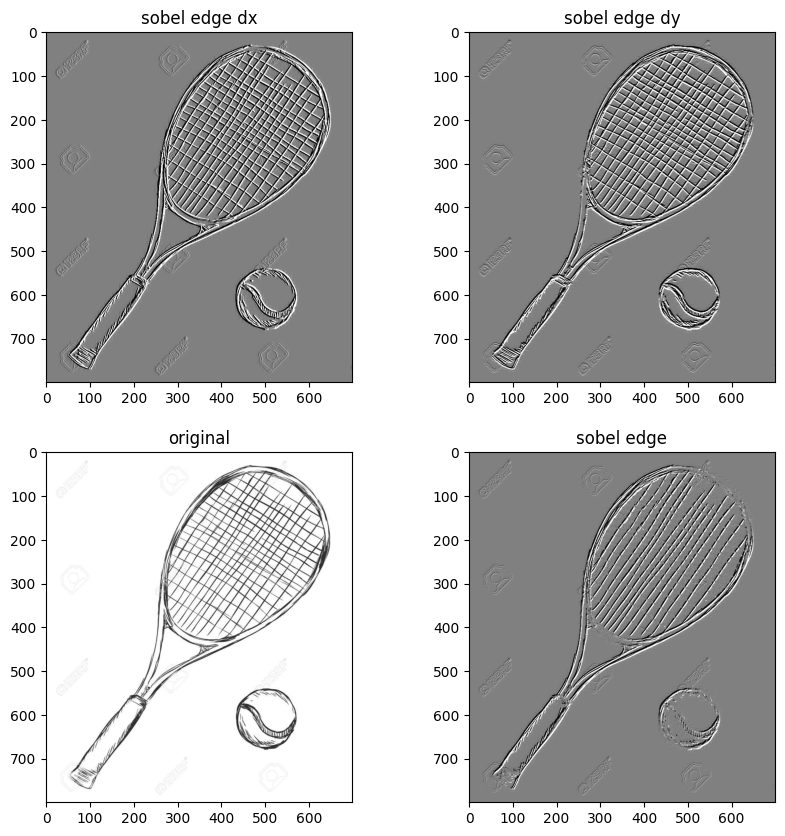

In [99]:
# 소벨 엣지 추출

dx = cv2.Sobel(img, -1, 1, 0, delta=128)  # depth, dx, dy 순
dy = cv2.Sobel(img, -1, 0, 1, delta=128)

absX = cv2.convertScaleAbs(dx)
absY = cv2.convertScaleAbs(dy)
output_img = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)

plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
plt.title('sobel edge dx')
plt.imshow(dx, cmap='gray')

plt.subplot(2,2,2)
plt.title('sobel edge dy')
plt.imshow(dy, cmap='gray')

plt.subplot(2,2,3)
plt.title('original')
plt.imshow(img, cmap='gray')

plt.subplot(2,2,4)
plt.title('sobel edge')
plt.imshow(output_img, cmap='gray')


plt.show()

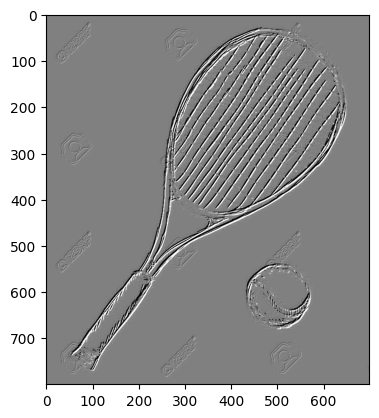

In [96]:
# sobel = cv2.magnitude(dx, dy)
# sobel = np.clip(sobel, 0, 255).astype(np.uint8)

absX = cv2.convertScaleAbs(dx)
absY = cv2.convertScaleAbs(dy)
output_img = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)

plt.imshow(output_img, cmap='gray')